# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 29th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 23 novembre 2020**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "bastien"
ln1 = "billiot"
fn2 = "simon"
ln2 = "demouchy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_billiot_bastien_and_demouchy_simon.ipynb


In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [ ]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [ ]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [ ]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j].copy()
        w[j] += A[:,j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:,j] * old_w_j - A[:,j] * w[j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(abs(gradient))
        old_w_j = w[j].copy()
        w[j] -= 1/lips_const[j] * gradient[j]
        # update gradient:
        gradient += gram[:,j] * w[j] - gram[:,j] * old_w_j
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [ ]:
# Advice : Always plot f(wt) - f(w*) as a function of t in the log space using semilogy (as alexandre did in notebooks --> we have to take it) 
# Use of some previous labs' functions

def loss(x, A, b):
  return norm(A.dot(x) - b) ** 2 / 2 

def grad(x, A, b):
  return A.T.dot(A.dot(x) - b)

In [ ]:
# Computation of a precise minimum with the solver scipy.optimize.fmin_l_bfgs_b
from scipy.optimize import fmin_l_bfgs_b, fmin_cg
w_ = np.zeros(n_features)
w_min, f_min, _ = fmin_l_bfgs_b(loss, w_, grad, args=(A, b), pgtol = 1e-30, factr = 1e-30)

In [ ]:
print(f_min)

466.3849765337659


In [ ]:
import time 
start = time.time()
w_c, obj_c = cyclic_cd(A, b, 3000)
print("cyclic time is %s seconds " % (time.time() - start))

start = time.time()
w_g, obj_g = greedy_cd(A, b, 3000)
print("greedy time is %s seconds " % (time.time() - start))

cyclic time is 0.07149672508239746 seconds 
greedy time is 0.07539749145507812 seconds 


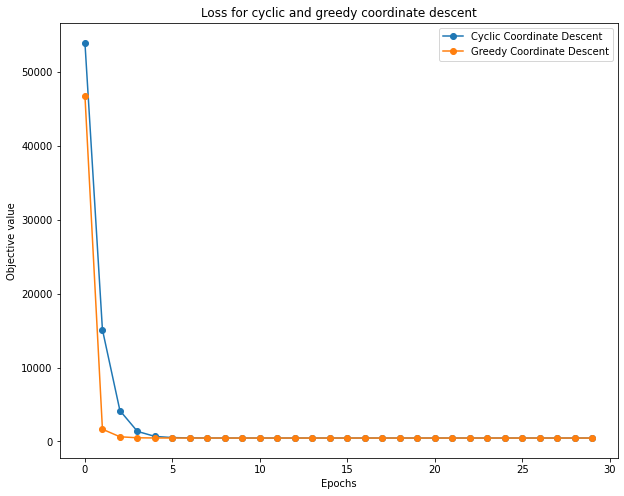

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(obj_c, 'o-', label='Cyclic Coordinate Descent')
plt.plot(obj_g, 'o-', label='Greedy Coordinate Descent')
plt.title('Loss for cyclic and greedy coordinate descent')
plt.xlabel('Epochs')
plt.ylabel('Objective value')

plt.legend()
plt.show()

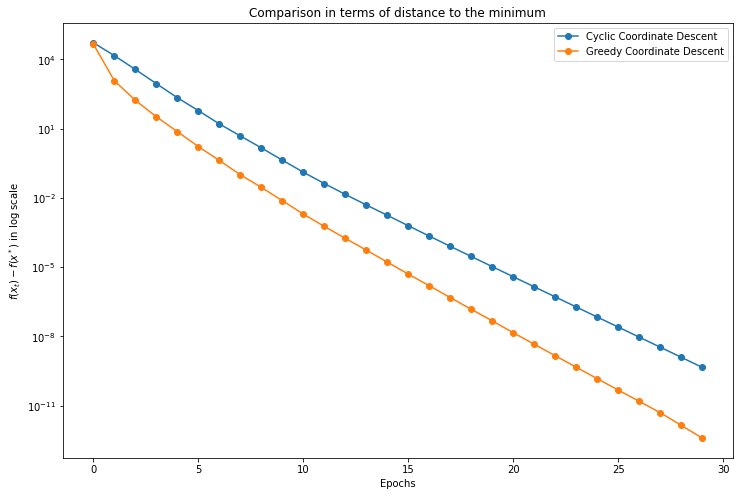

In [ ]:
plt.figure(figsize=(12,8))

plt.semilogy(obj_c - f_min , 'o-',label="Cyclic Coordinate Descent")
plt.semilogy(obj_g - f_min , 'o-',label="Greedy Coordinate Descent")

plt.xlabel("Epochs")
plt.ylabel("$f(x_t) - f(x^*)$ in log scale")
plt.legend()
plt.title("Comparison in terms of distance to the minimum")


plt.show()

In [ ]:
#distance to the minimizer obtained with fmin_l_bfgs_b
print ("error rate for cyclic CD : "+ str(norm(w_c-w_min, ord=2)))
print ("error rate for greedy CD : "+ str(norm(w_g-w_min, ord=2)))

error rate for cyclic CD : 1.14698137640042e-06
error rate for greedy CD : 3.716467289322087e-08


**Compare the performance of cyclic and greedy CD as function of iterations.** 

The first plotted graph show explicitly the decrease of the objective for both the cyclic and greddy coordinate descent to reach the minimum of 466.38. The graph also shows a steadier decrease for the greedy coordinate descent. 

The second graph shows that at the end of the 3,000 iterations, the distance to th minimum (obtained thanks to the L-BFGS optimizer) is smaller for the greedy CD compared to the cyclic CD (order of magnitude around $10^{-12}$ for greedy CD compared to $10^{-9}$ for cyclic CD). 

Comparing the final error rates, we also see that greedy CD gives an order of magnitude which is inferior to cyclic CD. 

In conclusion, greddy coordinate descent seems to outperform cyclic coordinate descent as less iterations are necessary to converge. 



**From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.**

We don't think we could use greedy CD for L2 regularized logistic regression. Indeed, L2 norm won't delete irrelevant features but will decrease the size of the coefficients. If the number of non zero coefficients is too large, greedy coordinate descent will be less efficient as it has to compute the entire gradient to select the required index. Therefore, greedy coordinate descent is more effective with sparse optimization, since the regularizer sets coefficients to zero, enabling the component never to be selected during the iterations. 

We don't think we could use greedy CD to solve OLS with 100,000 features. As greedy coordinate descent requires to look at the entire gradient in order to select the required index, a large number of features such as 100,000 would require a higher computational time and from a pratical point of view, with 100,000 features, this would be too probably too much. 

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)


Let $F(\omega) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$ and $f_i(\omega) = \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) \quad \forall i \in [1,n]$.

$\partial f_i(w) = \frac{-y_i x_i e^{- y_i w^\top x_i}}{1 + e^{- y_i w^\top x_i}}$


Therefore we have : $\partial F (\mathbf{0}_p) = \{ \frac{1}{2} \sum_{i = 1}^{n}(-y_i x_i) + \lambda \times a : a \in [-1,1]^p \}$ 

\begin{align*}
    \hat w = 0
    & \Leftrightarrow 0 \in -\frac{\sum_{i=1}^{n} y_i x_i}{2} + \lambda [-1, 1]^p \\
    & \Leftrightarrow \frac{\sum_{i=1}^{n} y_i x_i}{2} \in [-\lambda, \lambda]^p\\
    & \Leftrightarrow \frac{||X^{T}y||_{\infty}}{2} \in [-\lambda, \lambda]^p \\
    & \Leftrightarrow \lambda_{max} = \frac{||X^{T}y||_{\infty}}{2} \le \lambda
\end{align*}

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

<div class="alert alert-success">
We use $f$, the function for logistic regression :

$$f(w)=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$$

As we are looking for the coordinate-wise Lipschitz constant of the smooth term $\gamma_{j}$, we compute the derivative of $f$ to $w_j$ :

$$\frac {\partial f(w)}{\partial w_j}=\sum_{i=1}^{n} \frac{-y_i x_{ij} e^{-y_i w^\top x_i}}{1+e^{-y_i w^\top x_i}}$$
And then the second :

$$\frac {\partial^2 f(w)}{\partial w_j^2}=\sum_{i=1}^{n} \frac{y_i^2 x_{ij}^2 e^{-y_i w^\top x_i}}{(1+e^{-y_i w^\top x_i})^2}$$
However :

$$ \forall x \in \mathbb{R}, \frac {e^{-x}}{(1+e^{-x})^2} \leq \frac{1}{4}$$
And :$$\forall i, y_i^2 = 1 $$

So :$$\frac {\partial^2 f(w)}{\partial w_j^2} \leq \frac 14 \sum_{i=1}^{n} x_{ij}^2 = \frac{1}{4} \Vert X_j \Vert ^2$$

Thus, we can set $L_{j} = \frac{\Vert X_j \Vert ^2}{4}$
</div>

In [ ]:
def h(x):
  return np.exp(-x) / (1 + np.exp(-x))**2

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [ ]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)

    # TODO
    lips_const = (np.linalg.norm(X, axis=0)**2)/4 
    # END TODO
    
    all_objs = []
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j].copy()
            # TODO
            grad_j = np.sum(- y * X[:, j] * sigmoid(-y * Xw))
            w[j] = soft_thresh(w[j] - 1. / lips_const[j] * grad_j, lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += w[j] * X[:,j] - old_w_j * X[:,j]
            #END TODO

        all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))   
    
    return w, all_objs

In [ ]:
%%time
w_min_cd_logreg, obj_w_cd_logreg = cd_logreg(X, y, lamb, 2000)
print(obj_w_cd_logreg[-1])

370.90370359545807
CPU times: user 9.18 s, sys: 91.6 ms, total: 9.27 s
Wall time: 9.17 s


# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [ ]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [ ]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

The label is $\{ -1,1\}$, so we have to code Sparse Logistic Regression instead of Lasso.

Simple proximal gradient solver for the sparse logistic regression :

**Proximal gradient solver for the Lasso**

In [ ]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x)*np.maximum(np.abs(x)-lmbd,0)

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x,ord=1)

def loss_linreg(w):
    """Least squares loss"""
    return (1/2)*np.linalg.norm(y-np.dot(X,w), ord=2)**2

def grad_linreg(w):
    """Least squares gradient"""
    return -np.dot(X.T, y-np.dot(X,w))
#from scipy.optimize import check_grad
#check_grad(loss_linreg, grad_linreg, randn(p))

def smoothness_const_linreg(X):
    """Lipschitz smoothness constant for least squares loss"""    
    return (np.linalg.norm(X, ord=2))**2

In [ ]:
def PGD(w0, f, grad_f, R, prox_R, step, lmbd, n_iter=50):
    """Proximal gradient descent algorithm"""
    w = w0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    # Current objective
    obj = f(w) + R(w, lmbd)
    objectives.append(obj)
    for k in range(n_iter-1):
        w = prox_R(w - step*grad_f(w), lmbd*step)
        obj = f(w) + R(w, lmbd)
        objectives.append(obj)
    return w, np.array(objectives)

In [ ]:
L = smoothness_const_linreg(X)
w0 = np.zeros(X.shape[1])

w_min_pgd, obj_min_pgd = PGD(w0=w0, f=loss_linreg, grad_f=grad_linreg, R=L1_norm, prox_R=prox_L1, step=1/L, lmbd=lambd, 
                             n_iter=50)
print(obj_min_pgd[-1])

32.197691021665605


**Prox CD solver for the Lasso and compare them on this dataset**

In [ ]:
def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)

def cd_linreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter)
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(X, axis=0)**2
    all_objs[0] = (1/2)*(np.linalg.norm(y - Xw, ord=2))**2 + lamb * np.linalg.norm(w, ord=1)
    # END TODO
    
    for t in range(n_iter-1):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = np.dot(X[:,j], Xw - y)
            step = 1/lips_const[j]
            w[j] = soft_thresh(w[j] - step*grad_j, lamb*step)

            if old_w_j != w[j]:
                Xw += X[:,j].dot(w[j]-old_w_j)
            #END TODO  
        all_objs[t+1] = (1/2)*(np.linalg.norm(y - Xw, ord=2))**2 + lamb * np.linalg.norm(w, ord=1)
    return w, all_objs

In [ ]:
%%time
w_min_cd_linreg, obj_min_cd_linreg = cd_linreg(X, y, lambd, 50)
print(obj_min_cd_linreg[-1])

26.500197757964404
CPU times: user 3.09 s, sys: 94 ms, total: 3.19 s
Wall time: 3.08 s


**Compare**

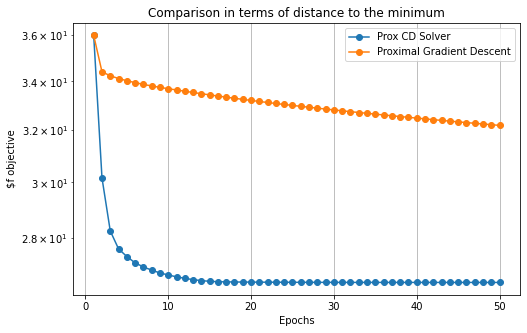

In [ ]:
plt.figure(figsize=(8, 5))

x = np.arange(1, len(obj_min_cd_linreg)+1)


plt.title("Comparison in terms of distance to the minimum")
plt.grid()

plt.plot(x, obj_min_cd_linreg, 'o-', label='Prox CD Solver')
plt.plot(x, obj_min_pgd, 'o-', label='Proximal Gradient Descent')
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("$f objective")
plt.legend()
plt.title("Comparison in terms of distance to the minimum")

plt.show()